# 1. Загрузка библиотек и обзор данных

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import matplotlib.patheffects as pe

In [2]:
# прочитаем тестовый файл
data = pd.read_csv('Тестовое задание - tz_data.csv')

# проведем первичный обзор данных
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 229 entries, 0 to 228
Data columns (total 8 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   area          228 non-null    object 
 1   cluster       228 non-null    float64
 2   cluster_name  228 non-null    object 
 3   keyword       228 non-null    object 
 4   good (1)      227 non-null    float64
 5   count         227 non-null    object 
 6   x             228 non-null    float64
 7   y             228 non-null    object 
dtypes: float64(3), object(5)
memory usage: 14.4+ KB


In [3]:
#проверим есть ли пустые строки и удалим их
data  = data.dropna()


# в столбцах присутсвуют неформатируемые данные, избавимся от них
data = data.query('y != "0x414fe002" ')
data = data.query('count != "N\\A" ')
data = data.query('count != "-" ')

# переведем данные в соотвествующие типы
data['count'] = data['count'].astype('int')
data['y'] = data['y'].astype('float64',errors ='ignore')

# проверем уникальный значения в столбцах с категориями
for column in ['area','cluster_name']:
    print(
        f'Уникальные значения в столбце {column}',
        '\n'*2,
        data[column].unique(), end = '\n'*2
    )

Уникальные значения в столбце area 

 ['eligibility' 'capability' 'available' 'protein' 'winner' 'locator'
 'worlds' 'ar\\vr' 'twisted' 'lithuania' 'personnel' 'housewives' 'dialog'
 'except' 'greetings']

Уникальные значения в столбце cluster_name 

 ['Кластер 0' 'Кластер 1' 'Кластер 2' 'Кластер 3']



При работе с данными строка 'ar\\vr' может привести к ошибке, так как обратный слэш в строке означает перевод строки, заменим слэш на нижнее подчеркивание

In [4]:
data.loc[data['area']== 'ar\\vr','area'] = 'ar_vr'

In [5]:
# создадим список из названий столбцов из задания:
# area, cluster, cluster_name, keyword, x, y, count, color

columns = [str(i) for i in input().split(sep = ', ')]
print(columns)

area, cluster, cluster_name, keyword, x, y, count, color
['area', 'cluster', 'cluster_name', 'keyword', 'x', 'y', 'count', 'color']


In [6]:
# создадим датафрейм со столбцами из задания
# столбец color также был создан
df = pd.DataFrame(data=data, columns=columns )

In [7]:
df.head()

,area,cluster,cluster_name,keyword,x,y,count,color
0,eligibility,0.0,Кластер 0,several animated buried,5.772342,12.564796,1260,NaN
1,eligibility,0.0,Кластер 0,singles unusual buyers,14.829280,7.850729,866,NaN
2,eligibility,0.0,Кластер 0,hawaiian directive,11.381856,3.898137,163,NaN
3,eligibility,0.0,Кластер 0,dynamics directly,9.980149,6.281428,1146,NaN
4,eligibility,1.0,Кластер 1,decision surgeons montreal,3.283940,4.396741,823,NaN


# 2. Определение признака (цвет) и выгрузка таблицы

Для начала проверим сколько уникальных значений из столбца area соответствует каждому кластеру и одинаковы ли эти значения в каждом кластере

In [8]:
# уникальные значения в столбце cluster:
uniq_values_lst = df['cluster'].unique()



for value in uniq_values_lst:
    ar_per_cl =  len(df.query(f'cluster == {value}')['area'].unique())
    ar_per_cl_values = sorted(
        df.query(f'cluster == {value}')['area'].unique()
    )
    areas_1st_cl = sorted (
        df.query('cluster == 0')['area'].unique()
    )
    if ar_per_cl_values == areas_1st_cl:
        print(
                f'В кластере {value} прсисутсвует {ar_per_cl} \
уникальных значений из столбца area и они соответсвуют \
значениям из других кластеров ','\n'
            )

В кластере 0.0 прсисутсвует 15 уникальных значений из столбца area и они соответсвуют значениям из других кластеров  

В кластере 1.0 прсисутсвует 15 уникальных значений из столбца area и они соответсвуют значениям из других кластеров  

В кластере 2.0 прсисутсвует 15 уникальных значений из столбца area и они соответсвуют значениям из других кластеров  

В кластере 3.0 прсисутсвует 15 уникальных значений из столбца area и они соответсвуют значениям из других кластеров  



Из условия задачи не совсем понятно как задавать цвет:

* внутри одной области цвета словосочетаний в одном кластере должны быть одинаковые, в разных - отличаться . <b> Отличаться в разных - далее не указан объект. В разных областях одного кластера или в одной области разных кластеров или в разных областях разных кластеров? </b>
* цвета кластеров в разных областях могут повторяться - <b> то есть в разных областях в разных кластерах цвета могут повторяться, что уменьшает опции выбора выше</b>

<b> Далее будет указан ход мыслей для случая, когда внутри одного кластера у разных областей будут разные цвета, но эти цвета могут повторяться у других областей других кластеров, затем я поменял ход мысли к случаю - один цвет для всех областей одного кластера, так как при выводе диаграммы рассеивания необходимо указать цвета кластеров, что при первом варианте будет промблематично сделать, если у разных областей разных кластеров будет один цвет </b>

Итого для каждого кластера есть 15 областей и эти области одинаковы для каждого кластера. Значит мы можем взять 15 цветов, по одному для каждой области. Но цвета одинковых областей в разных кластерах должны быть разными. Чтобы не использовать большее количество цветов, будем задавать цвет с шагом = 1. Так первой области из первого кластера зададим цвет n, этот же цвет зададим второй области из второго кластера и т.д.

In [9]:
# цвета для датфрейма
colors = [
    'aqua','blanchedalmond','blue',
    'blueviolet','crimson','darkgreen',
    'darkorange','gray','greenyellow',
    'indianred','lavender','lemonchiffon',
    'lightcoral','lime','magenta'
]

# создадим цикл, который пройдется по 
# каждой области каждого кластера и задаст цвет из списка
# при смене кластера в списке цветов будет происходть сдвиг на 1 шаг.

for cluster in uniq_values_lst:
    n = 0
    for area in areas_1st_cl:
        (
            df.loc[
                (df['area'] ==area) & (df['cluster'] == cluster),'color'
            ] )= colors[n]
        n +=1
    x = colors.pop(0)
    colors.append(x)

In [10]:
colors = [
    'green','red','blue',
    'blueviolet']
n = 0
for cluster in uniq_values_lst:
    (
        df.loc[(df['cluster'] == cluster),'color'
        ] )= colors[n]
    n += 1

Уберем дубликаты слов в одной и той же области (area) и проведем сортировку

In [11]:
df = df.drop_duplicates(subset=['area', 'keyword'],ignore_index = True) 

In [12]:

df = df.sort_values(
    ['area', 'cluster', 'cluster_name', 'count'], ascending = [False,False,False,True]
).reset_index(drop = True)

Экспортируем таблицу

In [13]:
with pd.ExcelWriter('output.xlsx') as writer:
    df.to_excel(writer, sheet_name = 'Sheet_1')

# 3. Создание диаграмм и выгрузка файлов

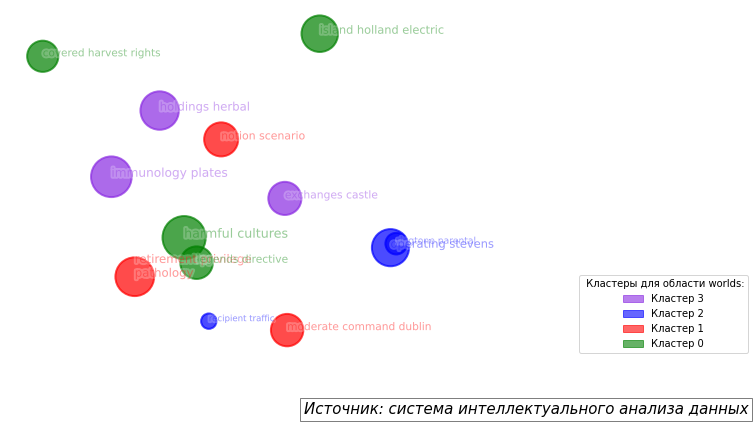

<Figure size 432x288 with 0 Axes>

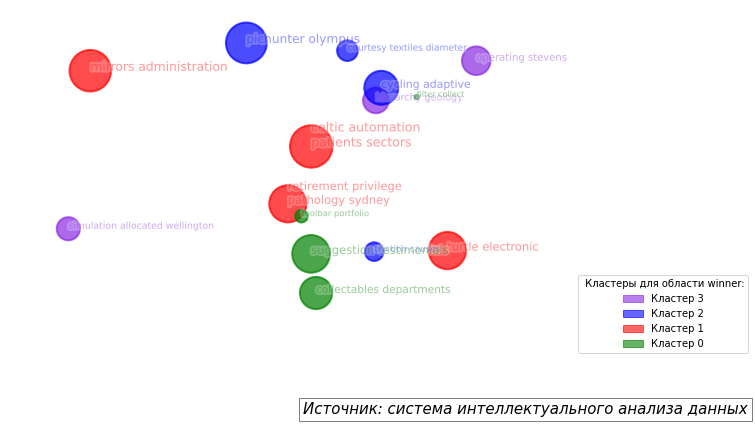

<Figure size 432x288 with 0 Axes>

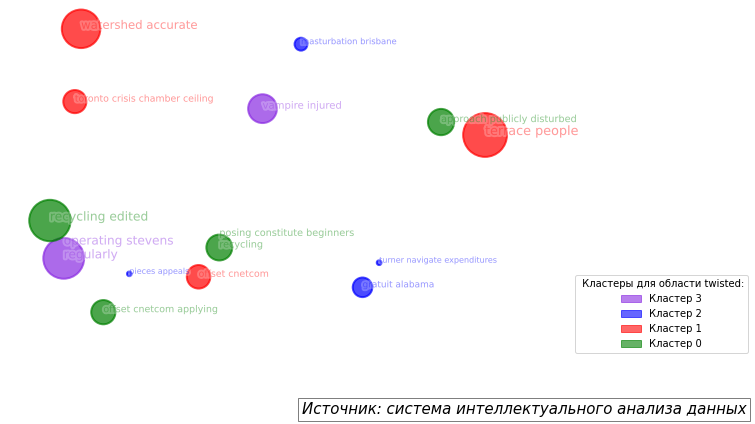

<Figure size 432x288 with 0 Axes>

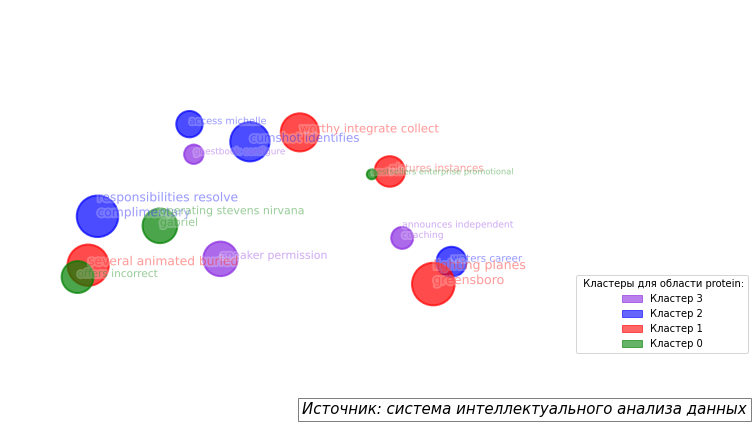

<Figure size 432x288 with 0 Axes>

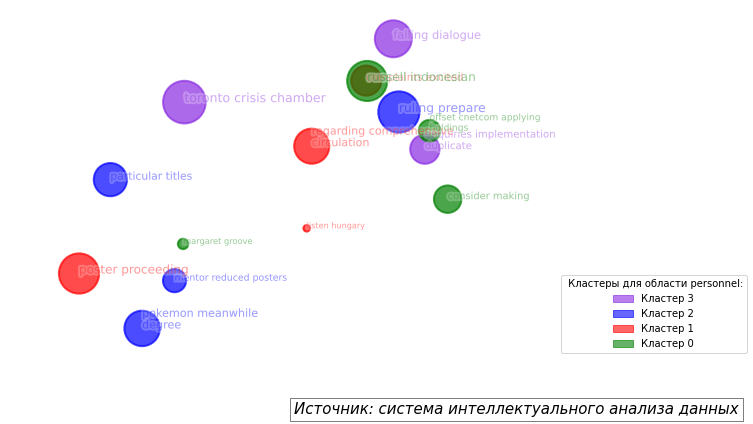

<Figure size 432x288 with 0 Axes>

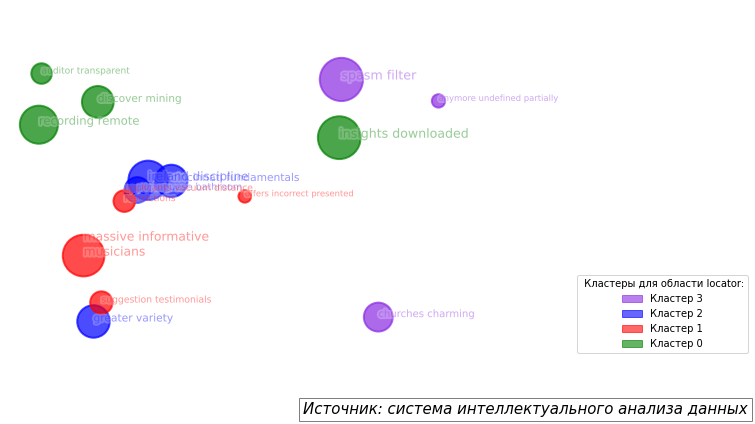

<Figure size 432x288 with 0 Axes>

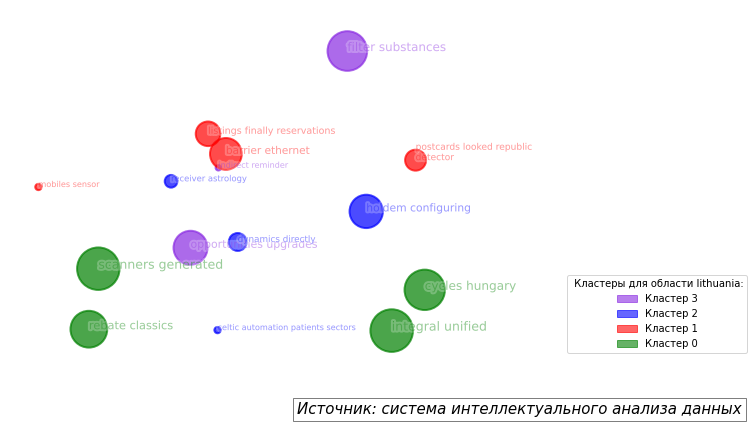

<Figure size 432x288 with 0 Axes>

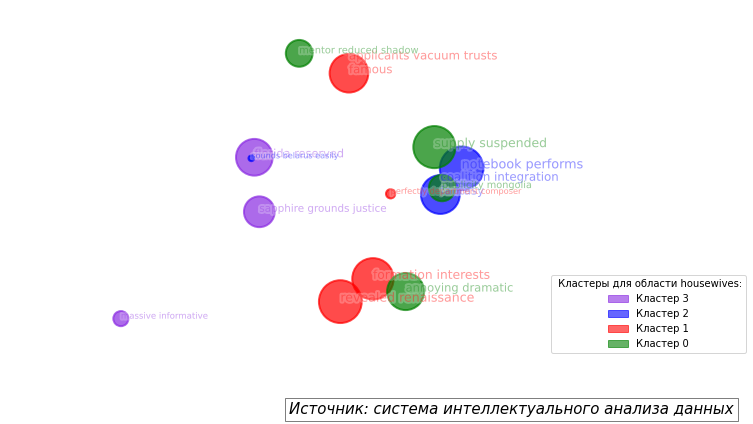

<Figure size 432x288 with 0 Axes>

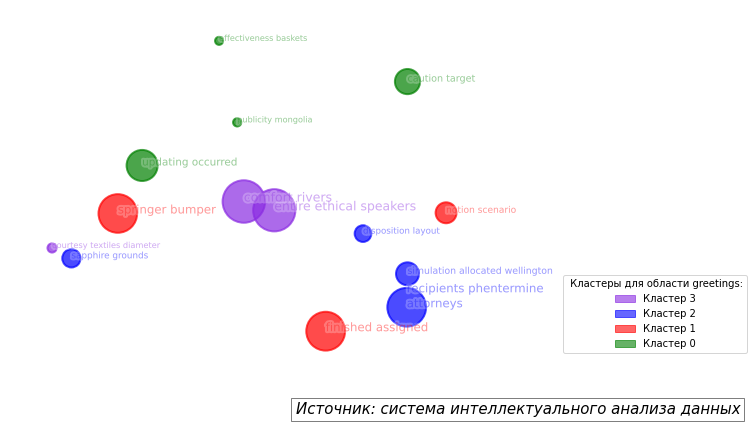

<Figure size 432x288 with 0 Axes>

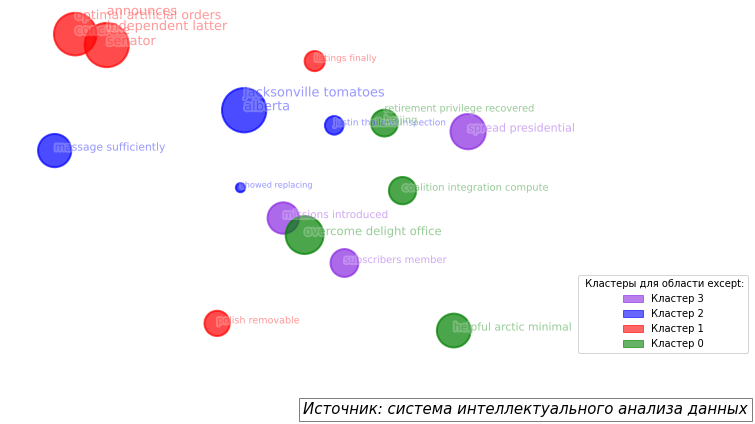

<Figure size 432x288 with 0 Axes>

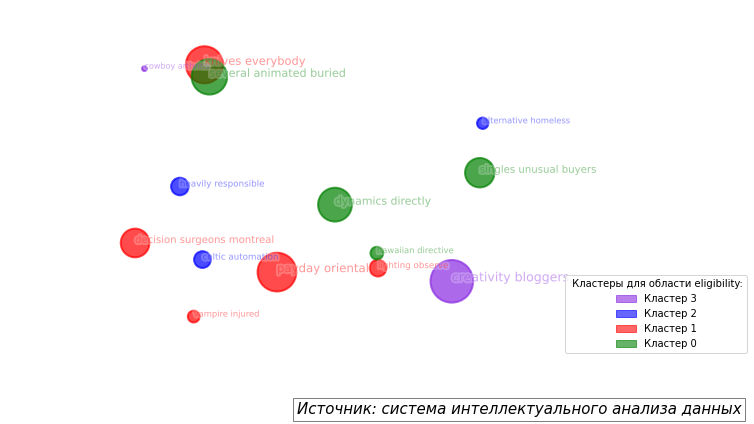

<Figure size 432x288 with 0 Axes>

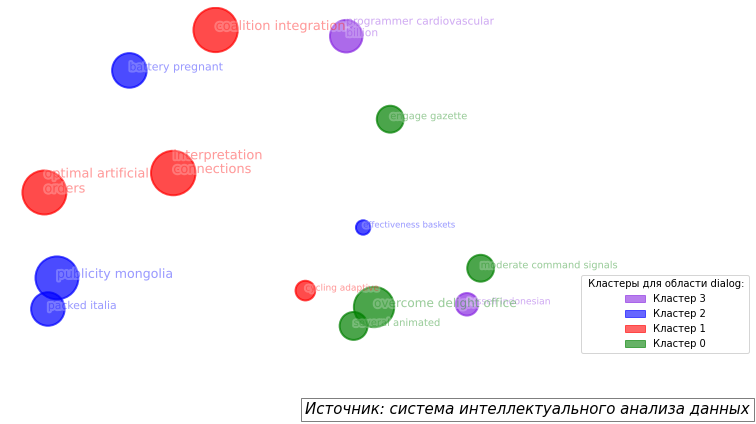

<Figure size 432x288 with 0 Axes>

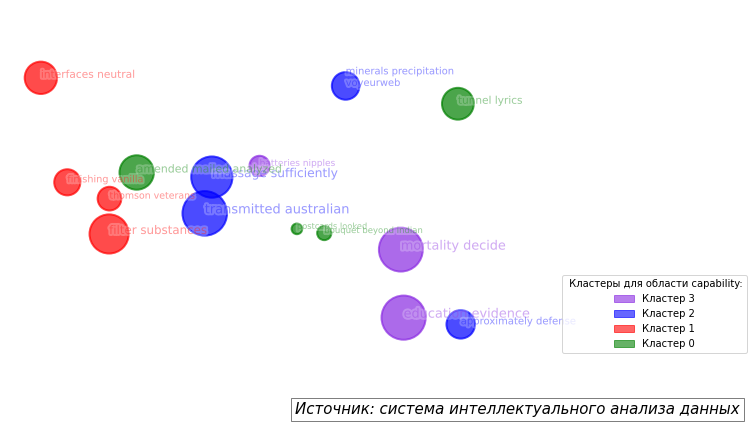

<Figure size 432x288 with 0 Axes>

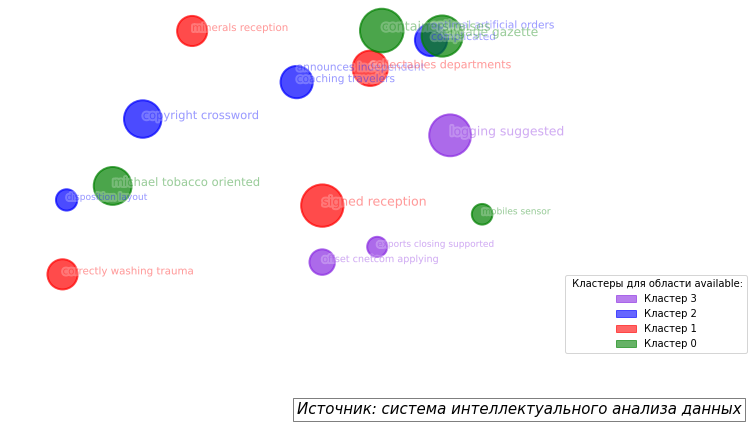

<Figure size 432x288 with 0 Axes>

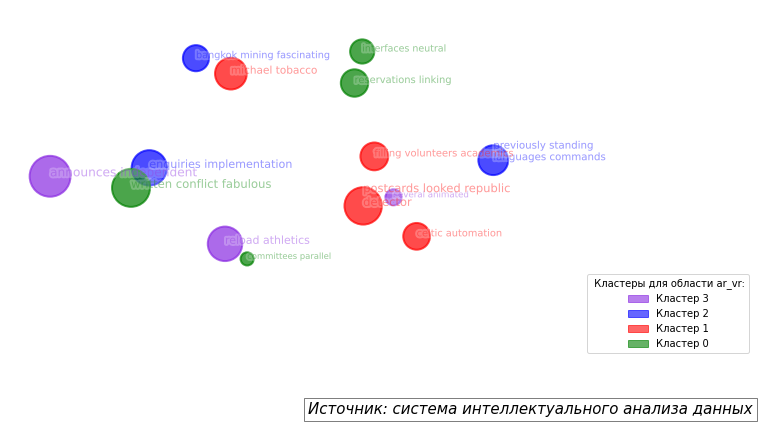

<Figure size 432x288 with 0 Axes>

In [15]:
n = 0
for ar in df['area'].unique():
    dm = df[df['area']== ar]
    fig, ax = plt.subplots(1, figsize=(11,6))
    plt.scatter(
        x = dm['x'],
        y = dm['y'],
        s = dm['count'],
        alpha = 0.7,
        c = dm['color'],
        label = '',
        linewidths = 2
    )
    plt.xlim(-1,16)
    plt.ylim(-1,16)
    for i,txt in enumerate(dm['keyword'],start = n):
        #plt.annotate(
        #    txt,(dm['x'][i],dm['y'][i]),color = dm['color'][i]
        #   ,alpha = 0.5, fontsize=(8+(dm['count'][i]/200)),
         #   path_effects=[pe.withStroke(linewidth=4, foreground="white")]
        #)
        ax.text(
            dm['x'][i],dm['y'][i],s = dm['keyword'][i],
            color = dm['color'][i],alpha = 0.25, fontsize=(8+(dm['count'][i]/400)),
            wrap=True,
            path_effects=[pe.withStroke(linewidth=4,foreground="white")],
            fontvariant = 'small-caps'
        )._get_wrap_line_width = lambda : 150
        n += 1


    clusters = list(dm['cluster_name'].unique())
    color_list = list(dm['color'].unique())
    l = []
    for i in range(0,len(clusters)):
        l.append(
            mpatches.Patch(color = color_list[i],
            alpha = 0.6,
            label = clusters[i])
                )
    plt.text(
        8.7, -4, "Источник: система интеллектуального анализа данных", fontsize=15,
        bbox=dict(facecolor='white', alpha=0.5),fontstyle = 'italic'
    )

    plt.legend(handles = l, loc = (1.10,0), title = f' Кластеры для области {ar}:')
    fig.tight_layout()
    ax.axis('off')
    fig1 = plt.gcf()
    plt.show();
    plt.draw()
    fig1.savefig(f'graph_for_{ar}.png',dpi = 1500,facecolor = 'white')
